In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import os
import keras
from keras_unet.models import custom_unet

Populating the interactive namespace from numpy and matplotlib


2023-03-31 01:12:24.091605: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/ESUS/'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')

In [3]:
images = np.load(images_file)
labels = np.load(labels_file)

In [4]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [5]:
p = np.random.permutation(len(images))

In [6]:
images = images[p]
labels = labels[p]

In [7]:
labels = labels.astype(np.float64)

In [8]:
images = images.astype(np.float64)

#normalize whole file
images = (images - images.min()) / (images.max() - images.min())    

In [9]:
images.shape, labels.shape

((766, 512, 512, 1), (766, 512, 512, 1))

In [10]:
import json

In [11]:
with open("image_data_v3.json", "r") as fp:
    image_data = json.load(fp)
with open("label_data_v3.json", "r") as fp:
    label_data = json.load(fp)

In [12]:
X_train = images[0:image_data['82']]
y_train = labels[0:label_data['82']]
X_val = images[image_data['82']:]
y_val = labels[label_data['82']:]

In [13]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 512, 512, 1) (2, 512, 512, 1)


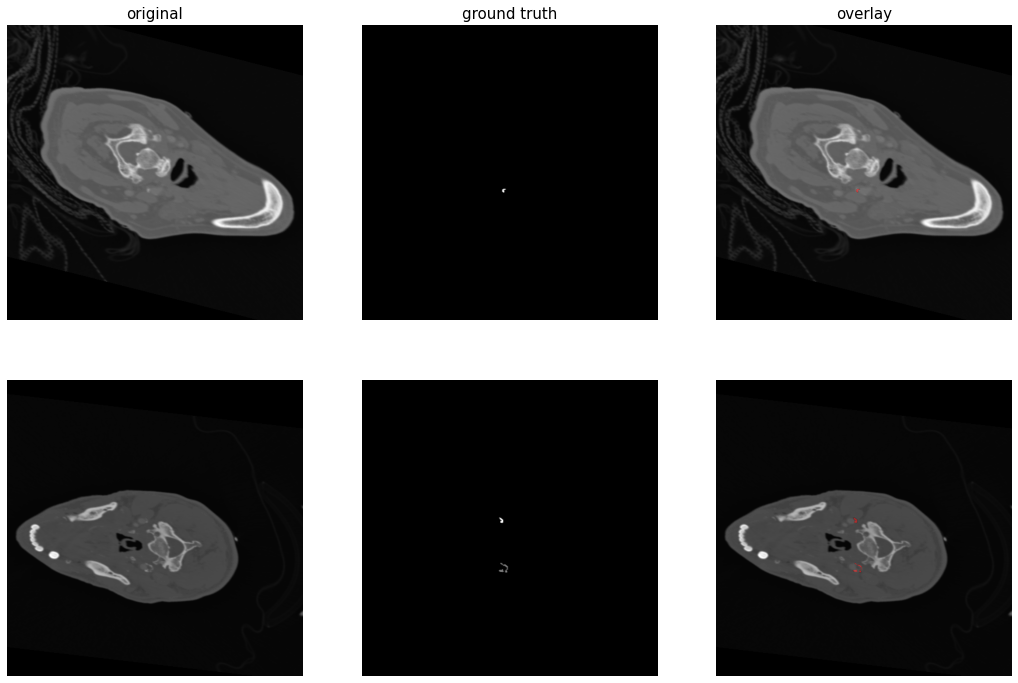

In [14]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)


In [15]:
model = custom_unet(
    input_shape=(512, 512, 1),
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.5,
    output_activation='sigmoid')

2023-03-31 01:13:00.770540: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-03-31 01:13:00.925055: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-03-31 01:13:00.925102: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-03-31 01:13:00.980208: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-03-31 01:13:00.980240: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-03-31 01:13:00.998272: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

In [16]:
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
from tensorflow.keras.optimizers import Adam

In [17]:
model.compile(optimizer = Adam(), # Adam(learning_rate=lr_schedule)
              loss='binary_crossentropy', 
              metrics=[iou, iou_thresholded])

In [18]:
history = model.fit(X_train, 
                    y_train, 
                    #train_gen,
                    #steps_per_epoch=32,
                    #epochs=200,
                    32,
                    epochs=200,
                    validation_data=(X_val, y_val)) # callbacks = [earlystopping]

2023-03-31 01:13:50.115173: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-03-31 01:13:50.118067: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/200


2023-03-31 01:13:51.365533: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-03-31 01:13:52.639770: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-03-31 01:13:54.170868: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-03-31 01:13:54.170892: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-03-31 01:13:54.171752: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-03-31 01:13:54.265913: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-03-31 01:13:55.659670: I tensorflow/stream_exec

19/19 [==============================] - 60s 2s/step - loss: 0.1331 - iou: 7.3489e-05 - iou_thresholded: 2.8550e-04 - val_loss: 0.0239 - val_iou: 7.3499e-05 - val_iou_thresholded: 3.1256e-04
Epoch 2/200
19/19 [==============================] - 19s 993ms/step - loss: 0.0205 - iou: 5.6196e-05 - iou_thresholded: 2.8303e-04 - val_loss: 0.0109 - val_iou: 8.6097e-05 - val_iou_thresholded: 3.1256e-04
Epoch 3/200
19/19 [==============================] - 19s 990ms/step - loss: 0.0098 - iou: 1.3574e-04 - iou_thresholded: 2.7629e-04 - val_loss: 0.0062 - val_iou: 3.6144e-04 - val_iou_thresholded: 3.1256e-04
Epoch 4/200
19/19 [==============================] - 19s 992ms/step - loss: 0.0055 - iou: 3.1565e-04 - iou_thresholded: 2.7598e-04 - val_loss: 0.0080 - val_iou: 9.0803e-04 - val_iou_thresholded: 3.1256e-04
Epoch 5/200
19/19 [==============================] - 19s 996ms/step - loss: 0.0044 - iou: 5.1826e-04 - iou_thresholded: 2.8942e-04 - val_loss: 0.0048 - val_iou: 0.0016 - val_iou_thresholded: 

19/19 [==============================] - 19s 989ms/step - loss: 0.0065 - iou: 2.6039e-04 - iou_thresholded: 2.8935e-04 - val_loss: 0.0055 - val_iou: 2.8738e-04 - val_iou_thresholded: 3.1256e-04
Epoch 43/200
19/19 [==============================] - 19s 992ms/step - loss: 0.0046 - iou: 3.6384e-04 - iou_thresholded: 2.8217e-04 - val_loss: 0.0042 - val_iou: 8.4224e-04 - val_iou_thresholded: 3.1256e-04
Epoch 44/200
19/19 [==============================] - 19s 988ms/step - loss: 0.0041 - iou: 5.5769e-04 - iou_thresholded: 2.7409e-04 - val_loss: 0.0045 - val_iou: 5.3585e-04 - val_iou_thresholded: 3.1256e-04
Epoch 45/200
19/19 [==============================] - 19s 991ms/step - loss: 0.0039 - iou: 7.1599e-04 - iou_thresholded: 2.8195e-04 - val_loss: 0.0043 - val_iou: 7.3043e-04 - val_iou_thresholded: 3.1256e-04
Epoch 46/200
19/19 [==============================] - 19s 991ms/step - loss: 0.0038 - iou: 9.6079e-04 - iou_thresholded: 2.7577e-04 - val_loss: 0.0042 - val_iou: 8.7301e-04 - val_iou_th

Epoch 83/200
19/19 [==============================] - 19s 993ms/step - loss: 0.0026 - iou: 0.0169 - iou_thresholded: 2.7933e-04 - val_loss: 0.0029 - val_iou: 0.0273 - val_iou_thresholded: 3.1256e-04
Epoch 84/200
19/19 [==============================] - 19s 988ms/step - loss: 0.0026 - iou: 0.0167 - iou_thresholded: 2.8625e-04 - val_loss: 0.0029 - val_iou: 0.0203 - val_iou_thresholded: 3.1256e-04
Epoch 85/200
19/19 [==============================] - 19s 992ms/step - loss: 0.0026 - iou: 0.0175 - iou_thresholded: 2.7939e-04 - val_loss: 0.0029 - val_iou: 0.0288 - val_iou_thresholded: 3.1256e-04
Epoch 86/200
19/19 [==============================] - 19s 992ms/step - loss: 0.0025 - iou: 0.0200 - iou_thresholded: 2.9314e-04 - val_loss: 0.0030 - val_iou: 0.0255 - val_iou_thresholded: 3.1256e-04
Epoch 87/200
19/19 [==============================] - 19s 988ms/step - loss: 0.0025 - iou: 0.0204 - iou_thresholded: 2.8078e-04 - val_loss: 0.0031 - val_iou: 0.0265 - val_iou_thresholded: 3.1256e-04
Epoch

19/19 [==============================] - 19s 988ms/step - loss: 0.0018 - iou: 0.1219 - iou_thresholded: 0.1717 - val_loss: 0.0020 - val_iou: 0.1299 - val_iou_thresholded: 0.2508
Epoch 126/200
19/19 [==============================] - 19s 995ms/step - loss: 0.0018 - iou: 0.1239 - iou_thresholded: 0.1866 - val_loss: 0.0019 - val_iou: 0.1433 - val_iou_thresholded: 0.1942
Epoch 127/200
19/19 [==============================] - 19s 987ms/step - loss: 0.0017 - iou: 0.1402 - iou_thresholded: 0.1983 - val_loss: 0.0019 - val_iou: 0.1428 - val_iou_thresholded: 0.2188
Epoch 128/200
19/19 [==============================] - 19s 993ms/step - loss: 0.0017 - iou: 0.1355 - iou_thresholded: 0.2125 - val_loss: 0.0019 - val_iou: 0.1581 - val_iou_thresholded: 0.2075
Epoch 129/200
19/19 [==============================] - 19s 988ms/step - loss: 0.0017 - iou: 0.1420 - iou_thresholded: 0.2032 - val_loss: 0.0020 - val_iou: 0.1750 - val_iou_thresholded: 0.2018
Epoch 130/200
19/19 [==============================] -

Epoch 168/200
19/19 [==============================] - 19s 990ms/step - loss: 0.0012 - iou: 0.1876 - iou_thresholded: 0.2430 - val_loss: 9.2102e-04 - val_iou: 0.1941 - val_iou_thresholded: 0.2323
Epoch 169/200
19/19 [==============================] - 19s 992ms/step - loss: 0.0010 - iou: 0.1793 - iou_thresholded: 0.2532 - val_loss: 7.0944e-04 - val_iou: 0.1911 - val_iou_thresholded: 0.2869
Epoch 170/200
19/19 [==============================] - 19s 986ms/step - loss: 0.0013 - iou: 0.1667 - iou_thresholded: 0.2190 - val_loss: 4.5706e-04 - val_iou: 0.1725 - val_iou_thresholded: 0.2606
Epoch 171/200
19/19 [==============================] - 19s 993ms/step - loss: 0.0014 - iou: 0.1543 - iou_thresholded: 0.2263 - val_loss: 2.2681e-04 - val_iou: 0.2364 - val_iou_thresholded: 0.2783
Epoch 172/200
19/19 [==============================] - 19s 988ms/step - loss: 8.3724e-04 - iou: 0.1945 - iou_thresholded: 0.2527 - val_loss: -4.3528e-04 - val_iou: 0.2173 - val_iou_thresholded: 0.3031
Epoch 173/200
1

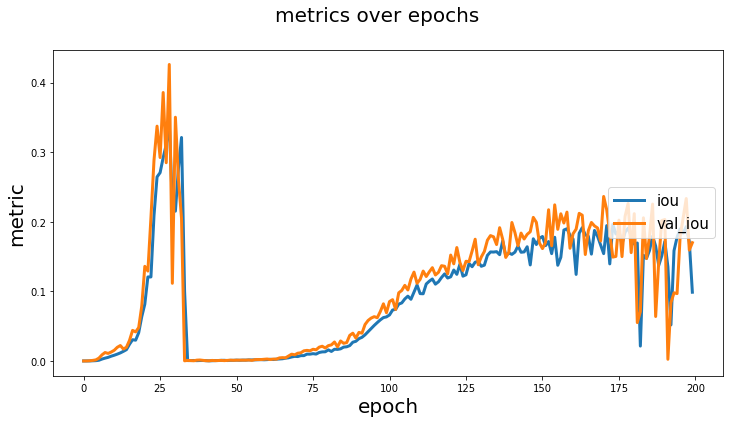

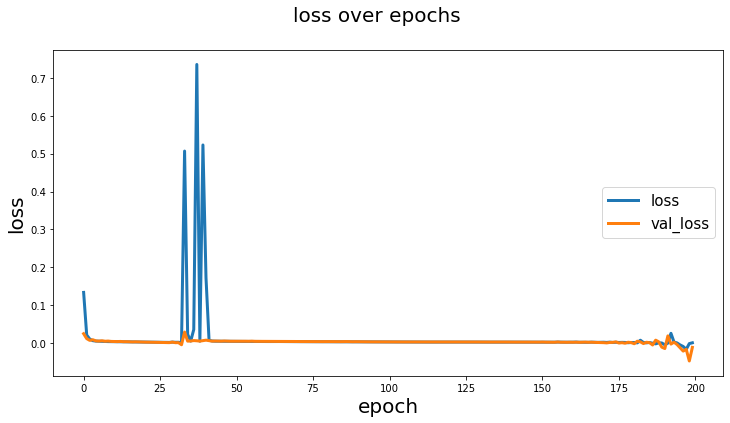

In [19]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [20]:
y_pred = model.predict(X_val)

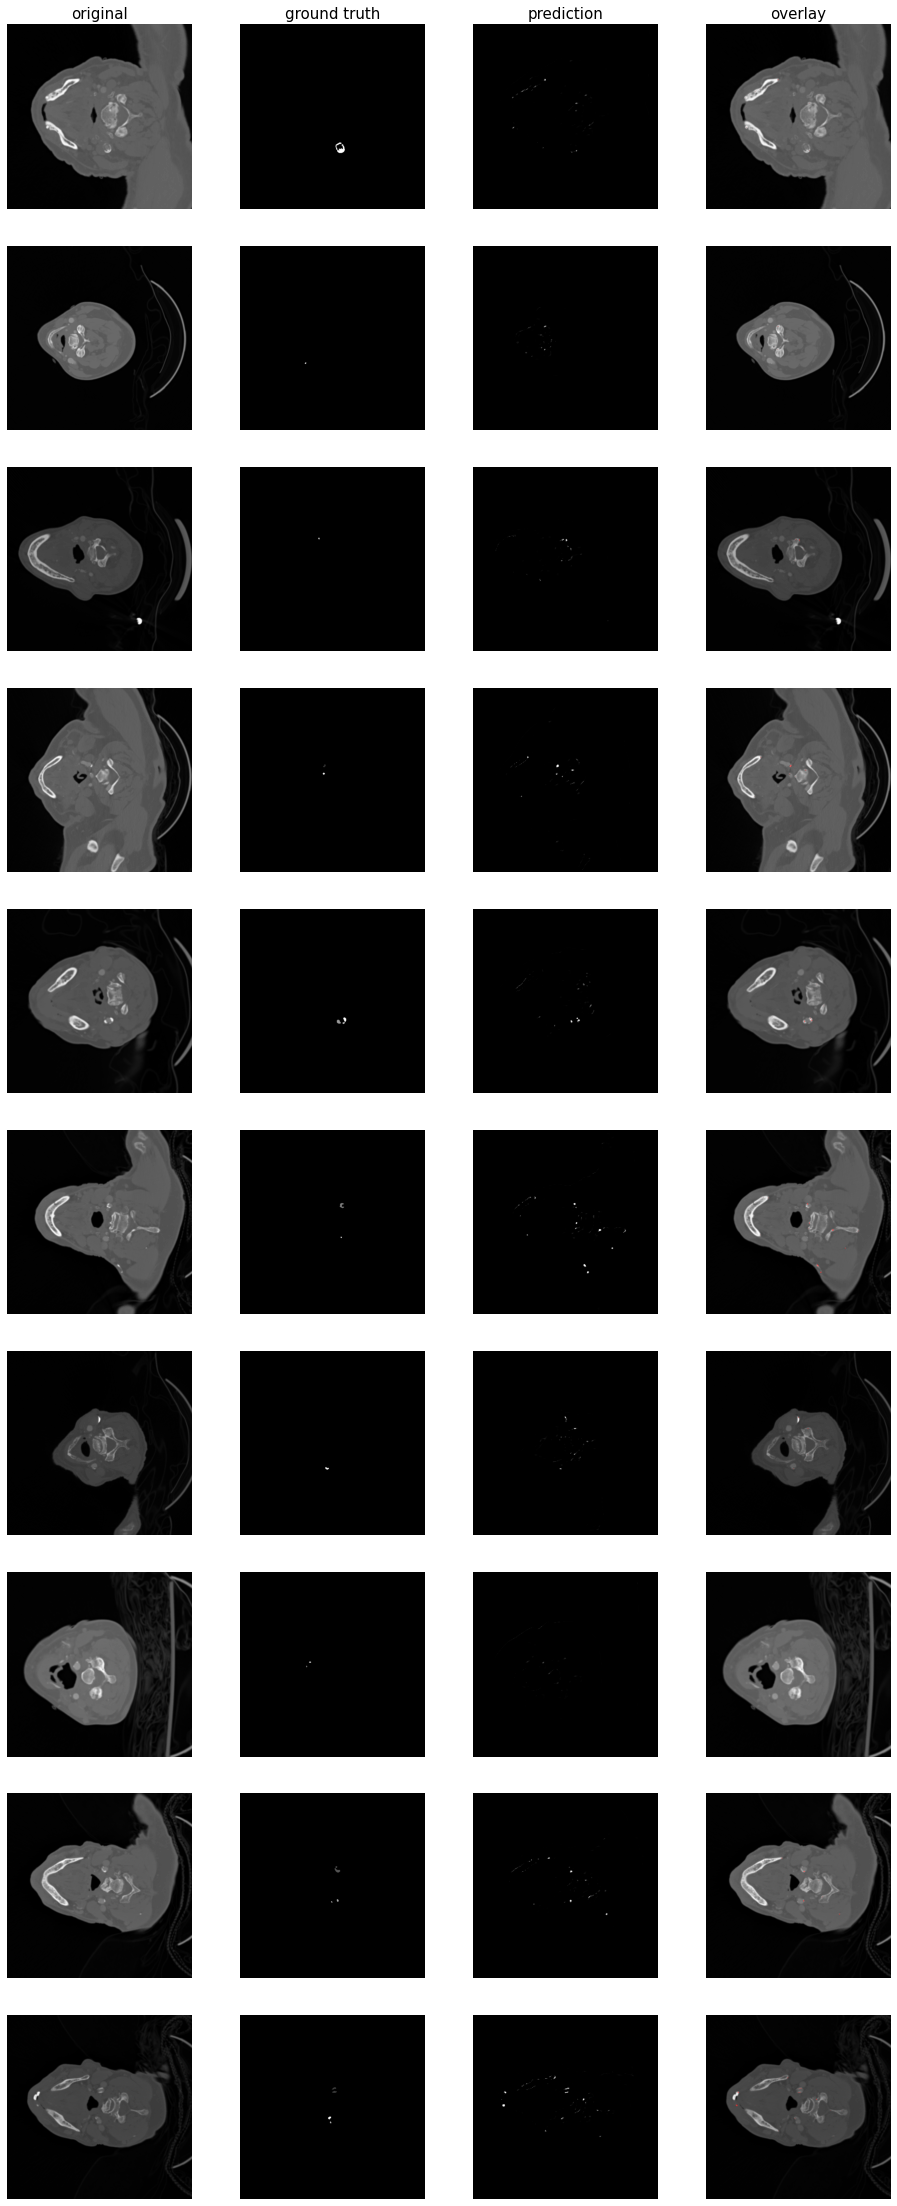

In [21]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10)

In [22]:
loss, iou, iou_thresholded = model.evaluate(X_val, y_val)

6/6 [==============================] - 1s 189ms/step - loss: -0.0123 - iou: 0.1700 - iou_thresholded: 0.2105
